# Командная часть проекта

In [102]:
data_config = {
    'spindalis' : {
    },
    'japonicum' : {
    },
    'bovis' : {
    },
    'mattheei' : {
    },
    'haematobium' : {
    },
    'mansoni' : {
    },
    'intercalatum': {
        'epigenetic_file' : 'epigenetic_genes.csv',
        'g4_file' : 'g4_segments.csv',
        'zrnk_file' : 'zrnk_segments.csv',
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/385/GCA_944470385.2_tdSchInte2.2/GCA_944470385.2_tdSchInte2.2_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/385/GCA_944470385.2_tdSchInte2.2/GCA_944470385.2_tdSchInte2.2_genomic.fna.gz'
    },
    'mekongi' : {
    },
}

In [117]:
# скачаем аннотации

# скачивание файлов генома и аннотации

import requests
import logging
import pathlib
import glob
import os
import sys
import itertools

logging.basicConfig(level=logging.INFO, force = True)

def download_file(url: str, local_file_name: pathlib.Path):
    if pathlib.Path(local_file_name).is_file():
        logging.info(f'file {local_file_name} already exists')
        return local_file_name
    logging.info(f'downloading {local_file_name}')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_file_name, 'wb') as out_file:
            for chunk in r.iter_content(chunk_size=8192): 
                out_file.write(chunk)

    return local_file_name

gff_files = dict()
fna_files = dict()

# скачиваем аннотации
for current_organism, current_data_config in data_config.items():
    if 'gff_url' in current_data_config:
        gff_files[current_organism] = download_file(current_data_config['gff_url'], f'data/{current_data_config['gff_url'].split('/')[-1]}')
    else:
        logging.warning(f'No gff url provided for {current_organism}')
    
    if 'fna_url' in current_data_config:
        fna_files[current_organism] = download_file(current_data_config['fna_url'], f'data/{current_data_config['fna_url'].split('/')[-1]}')
    else:
        logging.warning(f'No fna url provided for {current_organism}')

print(file=sys.stderr)

# распакуем сжатые файлы для удобства
for organism, filepath in itertools.chain(gff_files.items(), fna_files.items()):
    current_file_path = pathlib.Path(filepath)
    assert current_file_path.is_file()
    if current_file_path.suffix == '.gz':
        current_extracted_file = current_file_path.parent / pathlib.Path(filepath).stem
        if current_extracted_file.is_file():
            logging.info(f'{current_extracted_file} already exists')
        else:
            logging.info(f'extracting {current_extracted_file}')
            os.system(f'gunzip -k {current_extracted_file}')

for organism, filepath in gff_files.items():
    if pathlib.Path(filepath).suffix == '.gz':
        gff_files[organism] = current_file_path.parent / pathlib.Path(filepath).stem

for organism, filepath in fna_files.items():
    if pathlib.Path(filepath).suffix == '.gz':
        fna_files[organism] = current_file_path.parent / pathlib.Path(filepath).stem


INFO:root:file data/GCA_944470385.2_tdSchInte2.2_genomic.gff.gz already exists
INFO:root:file data/GCA_944470385.2_tdSchInte2.2_genomic.fna.gz already exists

INFO:root:data/GCA_944470385.2_tdSchInte2.2_genomic.gff already exists
INFO:root:data/GCA_944470385.2_tdSchInte2.2_genomic.fna already exists


In [106]:
# функции для чтения данных из результатов индивидуальных проектов

import pandas as pd
import pathlib

def get_epigenetic_genes(organism: str):
    assert organism in data_config, f'unknown organism: {organism}'

    if 'epigenetic_file' in data_config[organism]:
        file_name = data_config[organism]['epigenetic_file']
        if pathlib.Path(file_name).suffix == '.csv':
            res = pd.read_csv(f'data_in/{organism}/{data_config[organism]['epigenetic_file']}')
            res = res[['Gene_ID']]
            res.columns = ['gene']
            return res
        else:
            assert False, "Please, add support for your file type" # TODO
    else:
        logging.warning(f'No epigenetic_file specified for {organism}')
        return None


In [140]:
# установка меги

# https://drive.google.com/file/d/1beRdRYvyRw38orLmFiXE-p2paAILFvVm/view?usp=sharing


mega_file_id = "1beRdRYvyRw38orLmFiXE-p2paAILFvVm"
mega_url = f"https://drive.google.com/uc?export=download&id={mega_file_id}"

# скачивание меги

import requests
import pandas as pd
import pathlib
import logging

mega_gz = pathlib.Path('local_programs/mega.tar.gz')
mega_dir = pathlib.Path('local_programs/mega')

if mega_gz.is_file():
    logging.info(f'{mega_gz} already exists')
else:
    logging.info(f'downloading {mega_gz}')
    response = requests.get(mega_url)
    assert response.status_code == 200, 'Wrong status code'
    with open(mega_gz, 'wb') as out_file:
        out_file.write(response.content)

if not mega_dir.is_dir():
    logging.info(f'extracting {mega_gz}')
    ! cd local_programs/ && mkdir -p mega && tar -xzf mega.tar.gz -C mega
else:
    logging.info(f'already exists')

INFO:root:local_programs/mega.tar.gz already exists
INFO:root:extracting local_programs/mega.tar.gz


### 1. От каждого организма в группе Выбрать из генов отвечающих за эпигенетику 4-5 (как минимум 1 на члена группы) и построить для них выравнивания и деревья.

In [119]:
import logging

epigenetic_genes_for_alignment = []

for organism in data_config:
    current_epigenetic_genes = get_epigenetic_genes(organism)
    if current_epigenetic_genes is not None:
        current_epigenetic_genes_selected = current_epigenetic_genes.sample(5, random_state=42)
        assert len(current_epigenetic_genes_selected) == 5, 'too small current_epigenetic_genes_selected size'
        logging.info(f'Adding genes for {organism}')
        current_epigenetic_genes_selected['organism'] = organism
        epigenetic_genes_for_alignment.append(current_epigenetic_genes_selected)
    else:
        logging.warning(f'current_epigenetic_genes({organism}) is None')

epigenetic_genes_for_alignment = pd.concat(epigenetic_genes_for_alignment)
epigenetic_genes_for_alignment

INFO:root:Adding genes for intercalatum


,gene,organism
218,gene-SINT2_LOCUS1809,intercalatum
66,gene-SINT2_LOCUS5354,intercalatum
9,gene-SINT2_LOCUS3201,intercalatum
170,gene-SINT2_LOCUS4930,intercalatum
15,gene-SINT2_LOCUS5557,intercalatum


In [120]:
# Добавим в табличку хромосому координаты каждого

import logging

gene_organism_to_position = dict()

for _, row in epigenetic_genes_for_alignment.iterrows():
    gene_organism_to_position[(row['organism'], row['gene'])] = None

for organism in data_config:
    if organism in gff_files:
        with open(gff_files[organism], 'r') as gff_file:
            for row in gff_file:
                current_row = row.strip()
                if len(current_row) == 0 or current_row[0] == '#':
                    continue
                current_row_splitted = row.split()

                if current_row_splitted[2] == 'gene':
                    current_gene_id = current_row_splitted[8].split('ID=')[1].split(';')[0]
                    if (organism, current_gene_id) in gene_organism_to_position:
                        gene_organism_to_position[(organism, current_gene_id)] = (current_row_splitted[0], int(current_row_splitted[3]), int(current_row_splitted[4]))
    else:
        logging.warning(f'No such gff file for {organism}')

def get_position(row):
    res = gene_organism_to_position[(row['organism'], row['gene'])]
    return res

epigenetic_genes_for_alignment[['record_id', 'start', 'end']] = \
    epigenetic_genes_for_alignment.apply(get_position, axis=1, result_type='expand')

epigenetic_genes_for_alignment

,gene,organism,record_id,start,end
218,gene-SINT2_LOCUS1809,intercalatum,OX103876.1,69497234,69537522
66,gene-SINT2_LOCUS5354,intercalatum,OX103879.1,30466976,30476049
9,gene-SINT2_LOCUS3201,intercalatum,OX103877.1,38092074,38115003
170,gene-SINT2_LOCUS4930,intercalatum,OX103879.1,12765221,12771890
15,gene-SINT2_LOCUS5557,intercalatum,OX103879.1,37810964,37839258


In [131]:
# Добавим в табличку последовательность гена

import pandas as pd
import logging
from Bio import SeqIO

record_to_position = dict()

for _, row in epigenetic_genes_for_alignment.iterrows():
    if row['record_id'] not in record_to_position:
        record_to_position[row['record_id']] = dict()
    record_to_position[row['record_id']][(row['start'], row['end'])] = None

record_to_position

for organism in data_config:
    if organism in faa_files:
        records = list(SeqIO.parse(fna_files[organism], "fasta"))
        for record in records:
            if record.id in record_to_position:
                for requested_range in record_to_position[record.id]:
                    record_to_position[record.id][requested_range] = record.seq[requested_range[0]-1:requested_range[1]]

    else:
        logging.warning(f'No such fna file for {organism}')

def get_sequence(row):
    return [record_to_position[row['record_id']][(row['start'], row['end'])]]
        
epigenetic_genes_for_alignment[['data']] = \
    epigenetic_genes_for_alignment.apply(get_sequence, axis=1, result_type='expand')

epigenetic_genes_for_alignment['data'] = epigenetic_genes_for_alignment['data'].apply(lambda s : str(s).lower())
epigenetic_genes_for_alignment

,gene,organism,record_id,start,end,data
218,gene-SINT2_LOCUS1809,intercalatum,OX103876.1,69497234,69537522,atggatgtatgctttatttcatttaacttctaagatgcacttcatt...
66,gene-SINT2_LOCUS5354,intercalatum,OX103879.1,30466976,30476049,acagaataaaagaggtgtactgttaacaacagccagagtgcttttt...
9,gene-SINT2_LOCUS3201,intercalatum,OX103877.1,38092074,38115003,tctggttgtactggcggatgacttagaggtaggattttgttttcct...
170,gene-SINT2_LOCUS4930,intercalatum,OX103879.1,12765221,12771890,tcataaatgtaaccgtttagcacatgtaggtggtaatgacggtgat...
15,gene-SINT2_LOCUS5557,intercalatum,OX103879.1,37810964,37839258,gtttaagaagttgcgccttcttcagatcttagatggtattaacatt...


In [ ]:
# запишем последовательности в fasta файл
with open("data/epigenetic_genes_for_alignment.fasta", "w") as fasta_file:
    for _, row in epigenetic_genes_for_alignment.iterrows():
        seq_id, seq = f'{row['organism']}:{row['gene']}', row['data']
        fasta_file.write(f">{seq_id}\n{seq}\n")


# настройки меги для выравнивания
with open("data/muscle_align.mao", "w") as f:
    f.write("""; Please do not edit this file! If this file is modified, results are unpredictable.
; Instead of modifying this file, simply create a new MEGA Analysis Options file by using the MEGA Prototyper.
[ DataSettings ]
datatype                 = snNucleotide            
containsCodingNuc        = False                   
missingBaseSymbol        = ?                       
identicalBaseSymbol      = .                       
gapSymbol                = -                       
[ ProcessTypes ]
ppAlign                  = true                    
ppClustalW               = true                    
[ AnalysisSettings ]
Pairwise Alignment       = ====================    
DNAPWGapOpeningPenalty   = 15.00                   
DNAPWGapExtensionPenalty = 6.66                    
Multiple Alignment       = ====================    
DNAMAGapOpeningPenalty   = 15.00                   
DNAMAGapExtensionPenalty = 6.66                    
Global Options           = ====================    
DNA Weight Matrix        = IUB                     
TransitionWeightNEdit    = 0.50                    
UseNegativeMatrix        = ON                      
DelayDivergentCutoff     = 30                      
KeepPredefinedGaps       = True""")

# запуск меги
! ./local_programs/mega/megacc -a data/muscle_align.mao -d data/epigenetic_genes_for_alignment.fasta -o data/epigenetic_genes_alignment.meg

MEGA-CC 11.0.13 Molecular Evolutionary Genetics Analysis
Build#: 11220624-x86_64
06/15/2025 03:26:19 PM
Alignment settings:
                          : Pairwise Alignment                  : ====================
                          : DNAPWGapOpeningPenalty              : 15.00
                          : DNAPWGapExtensionPenalty            : 6.66
                          : Multiple Alignment                  : ====================
                          : DNAMAGapOpeningPenalty              : 15.00
                          : DNAMAGapExtensionPenalty            : 6.66
                          : Global Options                      : ====================
                          : DNA Weight Matrix                   : IUB
                          : TransitionWeightNEdit               : 0.50
                          : UseNegativeMatrix                   : ON
                          : DelayDivergentCutoff                : 30
                          : KeepPredefinedGaps    

In [ ]:
# настройки меги для построения дерева
with open("data/nj_tree.mao", "w") as f:
    f.write("""[ DataSettings ]
datatype                             = snNucleotide                        
containsCodingNuc                    = True                                
MissingBaseSymbol                    = ?                                   
IdenticalBaseSymbol                  = .                                   
GapSymbol                            = -                                   
[ ProcessTypes ]
ppInfer                              = true                                
ppML                                 = true                                
[ AnalysisSettings ]
Analysis                             = Phylogeny Reconstruction            
Statistical Method                   = Maximum Likelihood                  
Phylogeny Test                       = ====================                
Test of Phylogeny                    = Bootstrap method                    
No. of Bootstrap Replications        = 500                                 
Substitution Model                   = ====================                
Substitutions Type                   = Nucleotide                          
Model/Method                         = Kimura 2-parameter model            
Rates and Patterns                   = ====================                
Rates among Sites                    = Uniform Rates                       
No of Discrete Gamma Categories      = Not Applicable                      
Data Subset to Use                   = ====================                
Gaps/Missing Data Treatment          = Complete deletion                   
Site Coverage Cutoff (%)             = Not Applicable                      
Select Codon Positions               = 1st, 2nd, 3rd, Non-Coding           
Tree Inference Options               = ====================                
ML Heuristic Method                  = Nearest-Neighbor-Interchange (NNI)  
Initial Tree for ML                  = Make initial tree automatically (Neighbor Joining)
Branch Swap Filter                   = Strong                              
System Resource Usage                = ====================                
Number of Threads                    = 1                                   
Genetic Code Table                   = Not Applicable                      
Genetic Code                         = Not Applicable                      
Has Time Limit                       = False                               
Maximum Execution Time               = -1  """)

# запуск меги
! ./local_programs/mega/megacc -a data/nj_tree.mao -d data/epigenetic_genes_alignment.meg -o data/epigenetic_genes_tree.nwk

MEGA-CC 11.0.13 Molecular Evolutionary Genetics Analysis
Build#: 11220624-x86_64
06/15/2025 05:00:02 PM

Data file                                         : epigenetic_genes_alignment.meg
Status                                            : Reading header
Current Progress                                  : 1% 
Status                                            : Setting up genes/domains information                                      MEGA-CC has logged the following warning:
  When         = 06/15/2025 05:00:02 PM
  Data file    = data/epigenetic_genes_alignment.meg
  AnalysisFile = data/nj_tree.mao
  Parameter    = -o
  Parameter    = data/epigenetic_genes_tree.nwk
  Message      = One or more domains not specified as having coding data were found but the mao file calls for coding data. All domains will be treated as having coding data

  Please see the summary file for warnings/messages
  Please validate all your inputs and try again. If you think this is a
  bug, please report it at 


                 FigTree v1.4.4, 2006-2018
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
                 Uses the iText PDF Library
                    http://itextpdf.com/
               Uses the Apache Batik Library
            http://xmlgraphics.apache.org/batik/
                 Uses the JDOM XML Library
                    http://www.jdom.org/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating SVG graphic: data/epigenetic_genes_tree.svg


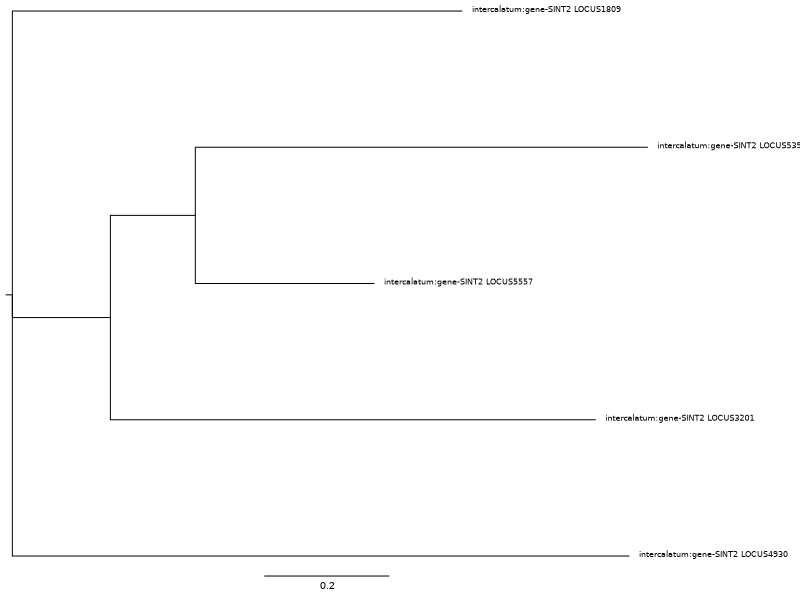

In [182]:
from IPython.display import SVG, display

# строим визуализацию дерева
! figtree -graphic SVG data/epigenetic_genes_tree.nwk data/epigenetic_genes_tree.svg
display(SVG(filename='data/epigenetic_genes_tree.svg'))

# более красивые картинки в отчете (тоже figtree, только через gui с настройками)

### 2. От каждого организма в группе выбрать 4-5 (как минимум 1 на члена группы)  генов (ортологов) в промоторах которых есть  квадруплексы и для этих квадруплексов построить выравнивание. И указать где есть вариации (в петле, числе повторов, выпетливания и т.п.) Если таких генов меньше, то для всех генов, что нашлись.